<a href="https://colab.research.google.com/github/lazy-wolf/TME_6017/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 2**

```
# Authoured by: Wasim Dawood Shaik
# UNB ID: 3744476
# Date: 19-02-2024
```

**Import Libraries**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from google.colab import drive
import tensorflow_hub as hub

**2. Data Collection and Preprocessing**

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Collect a dataset suitable for an image classification task. This could be images from a specific category or various classes that you are interested in classifying.**

In [3]:
train_directory = "/content/drive/MyDrive/TME_6017/Assignment_2/cats_and_dogs_filtered/train"

In [4]:
validation_directory = "/content/drive/MyDrive/TME_6017/Assignment_2/cats_and_dogs_filtered/validation"

**Preprocess the dataset for transfer learning. This includes resizing images, normalizing pixel values, and splitting the data into training and testing sets.**

In [5]:
batch_size = 32
image_size = (128, 128) # (image_height , image_width)

**Preparing the Training Dataset: Dataset Creation, Image Resizing, Batch Size Configuration.**

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

Found 2000 files belonging to 2 classes.


In [8]:
class_names = {0:'Cat',1:'Dog'}

**Showing Examples of Training Dataset**

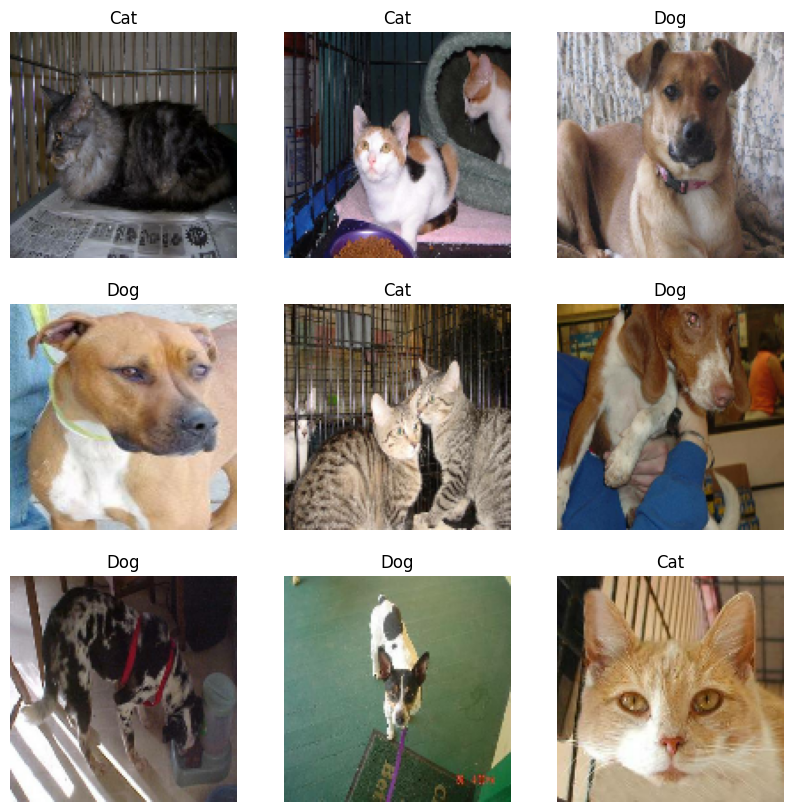

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy()])
    plt.axis("off")

**Preparing the Validation Dataset: Dataset Creation, Image Resizing, Batch Size Configuration.**

In [10]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_directory,
                                                                 shuffle=True,
                                                                 batch_size=batch_size,
                                                                 image_size=image_size)

Found 1000 files belonging to 2 classes.


**Preparing the Test Dataset.**

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

**Number of Batches for Training, Validation, and Test Datasets.**

In [12]:
print(f"Number of Batches in Training Dataset : {tf.data.experimental.cardinality(train_dataset)}")
print(f"Number of Batches in Validation Dataset : {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Number of Batches in Test Dataset : {tf.data.experimental.cardinality(test_dataset)}")

Number of Batches in Training Dataset : 63
Number of Batches in Validation Dataset : 26
Number of Batches in Test Dataset : 6


**Rescaling Training Dataset**

In [13]:
train_dataset = train_dataset.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))

**Rescaling Validation Dataset**

In [14]:
validation_dataset = validation_dataset.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))

**Rescaling Test Dataset**

In [15]:
test_dataset = test_dataset.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))

**Perform any necessary data augmentation to increase the diversity of your training data.**

In [16]:
augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x



In [17]:
data_augmentation_sample = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
])

**Plotting Data Augmentation on the Training Dataset Sample**

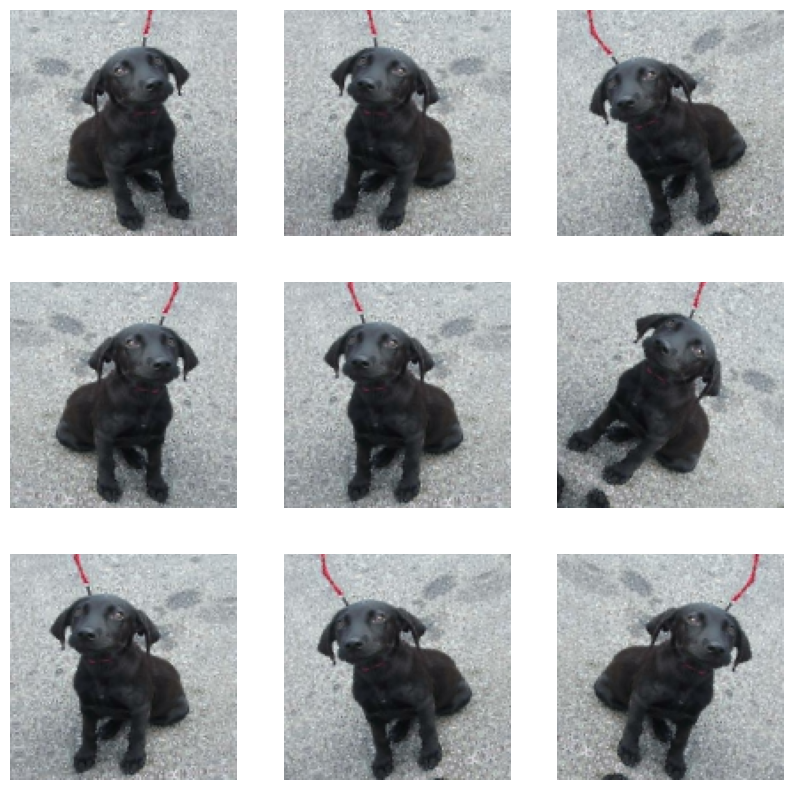

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation_sample(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

**Conducting Data Augmentation on the Training Dataset.**

In [19]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))


**Utilizing prefetching to enhance loading speed optimization.**

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE).cache()
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE).cache()
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE).cache()

**3. Implementing the Kaggle Model Backbone**

**kaggle Model Info**

[mobilenet-v2 link](https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2)

*https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2*

**Choose a pre-trained model available on Kaggle that you believe will work well with your dataset.**

In [21]:
model_handle = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

**Ensure the backbone layers are set to non-trainable, and only the top layer(s) are trainable (fine-tuning).**

In [22]:
kaggle_model_backbone = hub.KerasLayer(model_handle,
                                   trainable=False)

**Use TensorFlow to implement the model backbone.**

**Replace the top layer (output layer) of the model to suit the number of classes in your dataset.**

In [23]:
model = tf.keras.Sequential(
    [
        kaggle_model_backbone,
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)


In [24]:
model.build([None, 128, 128, 3])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 256)               256512    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1982026 (7.56 MB)
Trainable params: 289537 (1.10 MB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


**4. Training and Fine-Tuning**

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)




**Train and fine-tune the model on your collected dataset. Choose an appropriate batch size, learning rate, and number of epochs.**

In [27]:
history = model.fit(train_dataset, epochs=60, validation_data=validation_dataset)

Epoch 1/60
63/63 [==============================] - 24s 248ms/step - loss: 0.6363 - accuracy: 0.6540 - val_loss: 0.4972 - val_accuracy: 0.7661
Epoch 2/60
63/63 [==============================] - 1s 23ms/step - loss: 0.4563 - accuracy: 0.7900 - val_loss: 0.3859 - val_accuracy: 0.8490
Epoch 3/60
63/63 [==============================] - 2s 24ms/step - loss: 0.3699 - accuracy: 0.8405 - val_loss: 0.3300 - val_accuracy: 0.8676
Epoch 4/60
63/63 [==============================] - 1s 14ms/step - loss: 0.3201 - accuracy: 0.8745 - val_loss: 0.2972 - val_accuracy: 0.8812
Epoch 5/60
63/63 [==============================] - 1s 13ms/step - loss: 0.2874 - accuracy: 0.8890 - val_loss: 0.2759 - val_accuracy: 0.8886
Epoch 6/60
63/63 [==============================] - 1s 16ms/step - loss: 0.2641 - accuracy: 0.9075 - val_loss: 0.2609 - val_accuracy: 0.8923
Epoch 7/60
63/63 [==============================] - 1s 17ms/step - loss: 0.2462 - accuracy: 0.9120 - val_loss: 0.2497 - val_accuracy: 0.8960
Epoch 8/60


**Save the training history for further analysis.**

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history_mobilenet_v2= pd.DataFrame(history.history)
history_mobilenet_v2.head()

,loss,accuracy,val_loss,val_accuracy
0,0.636317,0.6540,0.497192,0.766089
1,0.456337,0.7900,0.385931,0.849010
2,0.369944,0.8405,0.329986,0.867574
3,0.320061,0.8745,0.297227,0.881188
4,0.287390,0.8890,0.275934,0.888614


**5. Model Evaluation and Insights**

**Evaluate the performance of your fine-tuned model on the testing set.**

In [31]:
loss, accuracy= model.evaluate(test_dataset)
print(f"loss is: {loss}")
print(f"accuacy is: {accuracy}")

6/6 [==============================] - 1s 105ms/step - loss: 0.1952 - accuracy: 0.9115
loss is: 0.19519369304180145
accuacy is: 0.9114583134651184


**Analyze the results and discuss any challenges you encountered, such as overfitting or underfitting.**

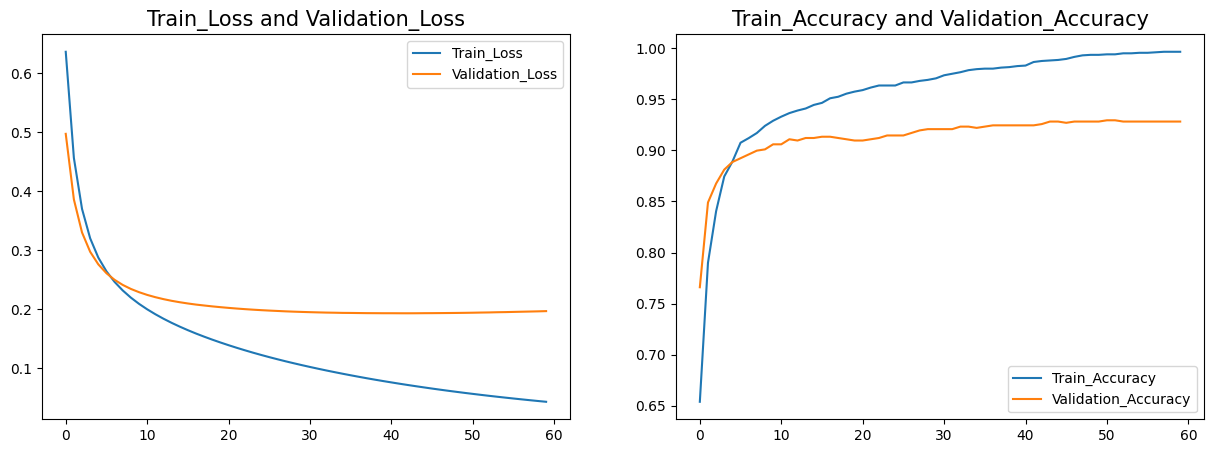

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_mobilenet_v2['loss'],label='Train_Loss')
plt.plot(history_mobilenet_v2['val_loss'],label='Validation_Loss')
plt.title('Train_Loss and Validation_Loss',fontsize=15)
plt.legend()


plt.subplot(1,2,2)
plt.plot(history_mobilenet_v2['accuracy'],label='Train_Accuracy')
plt.plot(history_mobilenet_v2['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy and Validation_Accuracy',fontsize=15)
plt.legend()
plt.show()